In [1]:
from pyraysum import prs, Geometry, Model, Control
import numpy as np
import os
import obspy as op
import pandas as pd
from scipy.optimize import dual_annealing, shgo, differential_evolution
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import LinearConstraint, Bounds
import ast

In [2]:
# reading the data
path_to_data = "DATA/RF"
station = "FCC"
def reading_rfs(keyword: str, filters=(0.05, 0.3), corners = 4, sort=None, t_snr_treshold=-10, path_to_data="DATA/waveforms_list.csv") -> tuple:
    """
    Reading RF data by the name of keyword as station code
    inputs:
    keyword: str
        station code
    t_snr_treshold: float
        signal to noise ratio treshold for transverse component (default 0, means no treshold)

    outputs:
    obser: np.array
        observed data in numpy array format
    baz: list
        corresponding back azimuth
    slow: list
        corresponding slowness
    """
    baz = []
    slow = []
    waveforms_list = pd.read_csv("DATA/waveforms_list.csv")
    filtered_files = waveforms_list[waveforms_list['sta_code']==keyword].copy()
    filtered_files = filtered_files[filtered_files['rf_quality'] == 1].copy()
    path = "DATA/RF/"
    npts = 426 * 2   
    dt = 0.2
    obser = np.zeros((len(filtered_files), npts))
    
    # function to calculate signal to noise ratio for transverse component
    def cal_snr_for_transverse(rft: np.array) -> np.array:
        noise = rft[:213]
        signal = rft[213:]
        return np.sum(np.square(signal)) / np.sum(np.square(noise))
    
    idx = 0
    for _, row in filtered_files.iterrows():
        wave_path = os.path.join(path, row['file_name']+".pkl")
        st = op.read(wave_path)
        RFR = st.select(channel="RFR")[0].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        RFT = st.select(channel="RFT")[0].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        #check if the signal to noise ratio is above the treshold
        if cal_snr_for_transverse(RFT) > t_snr_treshold:
            baz.append(st[0].stats.baz)
            slow.append(st[0].stats.slow)
            RFR = RFR / np.max(np.abs(RFR))
            RFT = RFT / np.max(np.abs(RFT))
            obser[idx, :426] = RFR
            obser[idx, 426:] = RFT
            idx += 1
    obser = obser[:idx, :]
    # sorting based on back azimuth or slowness
    if sort != None:
        zipped = list(zip(obser, baz, slow))
        if sort == "baz":
            zipped.sort(key=lambda x: x[1])
        elif sort == "slow":
            zipped.sort(key=lambda x: x[2])
        obser, baz, slow = zip(*zipped)
    obser = np.array(obser)
    return obser, baz, slow



# reading the model
def read_model(path_to_models, layer):
    """
    Reading the initials bounds and values
    Inputs:
        path_to_models: str: path to the models
        layer: int: layer number
    Outputs:
        bounds: list: bounds of the model
        fixed_vales: list: fixed values of the model
        mask: np.array: mask for the non-fixed values
    """
    bounds = pd.read_csv(os.path.join(path_to_models, "bounds.csv"))
    fixed_vales = pd.read_csv(os.path.join(path_to_models, "fixed_values.csv"))
    bounds = bounds[bounds["layer_code"] == layer].drop(columns=["layer_code"])
    fixed_vales = fixed_vales[fixed_vales["layer_code"] == layer].drop(columns=["layer_code"])
    
    #fix a bug
    # if fixed_vales.loc[len(fixed_vales.ani)-1, "ani"] == None:
    #     fixed_vales.loc[len(fixed_vales.ani)-1, "ani"]=np.nan
    
    bounds = bounds.values.flatten()
    # create a mask for the non-fixed values
    mask = pd.notna(bounds)
    bounds = [ast.literal_eval(i) for i in bounds if str(i) != 'nan']
    return bounds, fixed_vales, mask

def pyraysum_func(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani, npts, dt) -> tuple:
    model = Model(thickn, rho, vp, vs=vs, strike=strike, dip=dip, plunge=plunge, trend=trend, ani=ani)
    geom = Geometry(baz, slow)
    rc = Control(wvtype="P", rot="RTZ", mults=2, verbose=False, npts=npts*1, dt=dt, align=1, shift=5)
    result = prs.run(model, geom, rc, rf=True)
    result.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
    return result

def predict(model: pd.DataFrame, baz, slow, filters=(0.05, 0.3), corners=4):
    result = pyraysum_func(baz, slow, model["thickn"], model["rho"], model["vp"], model["vs"], model["dip"],
                                     model["strike"], model["plunge"], model["trend"], model["ani"], 3*426, 0.2)
    #lower number of samples would be problematic and that is why we produce longer signal and then reduce it
    pred = np.zeros((len(result), 2*426)) 
    pred_r = np.zeros((len(result), 3*426))
    pred_t = np.zeros((len(result), 3*426))

    for idx, i in enumerate(result):
        RFR = i[1][0].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        RFT = i[1][1].filter('bandpass', freqmin=filters[0], freqmax=filters[1], corners=corners, zerophase=True).data
        pred_r[idx, :] = RFR / np.max(np.abs(RFR))
        pred_t[idx, :] = RFT / np.max(np.abs(RFT))
    #making more samples to reduce the effect of the edges
    pred_r = pred_r[:, 426:2*426]
    pred_t = pred_t[:, 426:2*426]
    pred[:, :426], pred[:, 426:] = pred_r, pred_t
        #reducing the length of the data to 426
    return pred

def cost_func(variables, fixed_values, mask, obser, baz, slow, layer):
    """
    """
    keys = fixed_values.keys()
    fixed_values = fixed_values.values.flatten()
    fixed_values[mask] = variables
    model = fixed_values.reshape(layer, 9)
    model = pd.DataFrame(model, columns=keys)
    pred = predict(model, baz, slow)
    loss = np.sum(np.square(obser - pred))/426
    return loss

def optimize_model(bounds, fixed_values, mask, obser, baz, slow, layer):
    result = differential_evolution(cost_func,
                                    bounds,
                                    args=(fixed_values, mask, obser,
                                          baz, slow, layer),
                                    maxiter=2,
                                    disp=True,
                                    init="sobol",
                                    updating="deferred")
    return result
    



In [3]:
#Control 
filters = (0.05, 0.3)
corners = 4
path_to_models = "inv/initial"
layer = 3
path_to_data = "DATA/RF"
station = "BLKN"

#reading RFs
obser, baz, slow = reading_rfs(station, t_snr_treshold=4, sort="baz", filters=filters, corners=corners)
print("Station:", station,"- Observation Data Size:", obser.shape)
# reading the model bounds and fixed values
bounds, fixed_values, mask = read_model(path_to_models, layer)
mask

Station: BLKN - Observation Data Size: (8, 852)


array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True])

In [4]:
results = optimize_model(bounds, fixed_values, mask, obser, baz, slow, layer)

differential_evolution step 1: f(x)= 0.839072
differential_evolution step 2: f(x)= 0.839072
Polishing solution with 'L-BFGS-B'


In [5]:
flatten_x = fixed_values.values.flatten()
flatten_x[mask] = results.x
flatten_x = flatten_x.reshape(layer, 9)
flatten_x = pd.DataFrame(flatten_x, columns=fixed_values.columns)
os.makedirs(f"inv/results/{station}", exist_ok=True)
flatten_x.to_csv(f"inv/results/{station}/model_{station}_{layer}_layer.csv", index=False)
flatten_x

,thickn,rho,vp,vs,dip,strike,plunge,trend,ani
0,19884.551201,2173.726195,6421.990635,3068.596315,0.000000,0.000000,15.358854,171.322545,1.771040
1,9738.204934,2604.292179,7003.654261,3629.623549,6.303146,170.277178,19.385439,31.696223,6.133217
2,0.000000,3500.000000,8100.000000,4500.000000,4.515385,307.922719,1.436544,19.671154,9.566014


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

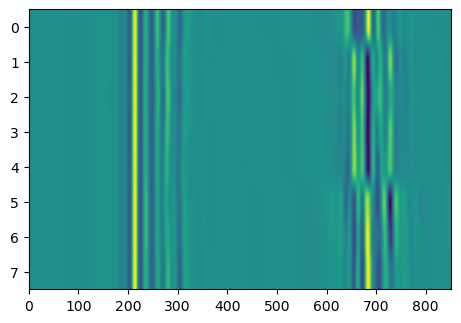

In [8]:
import matplotlib.pyplot as plt
time = np.arange(-213/5, 213/5, 5)
pred_data = predict(flatten_x, baz, slow)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(pred_data, aspect="auto")
plt.set_xlabel("Time")
plt.xticks(time)
plt.title("RFR - Predicted")
plt.subplot(2, 2, 2)
plt.imshow(time, obser, aspect="auto")
plt.title("RFR - Observed")
plt.subplot(2, 2, 3)
plt.imshow(time, pred_data, aspect="auto")
plt.title("RFT - Predicted")
plt.subplot(2, 2, 4)
plt.imshow(time, obser, aspect="auto")
plt.title("RFT - Observed")


